In [7]:
# First going to work out some ideas in a jupyter notebook - Later I will clean this
# up and and create some proper code.

from typing import Iterator, NamedTuple

# Getting some tensorflow warnings, but don't care about those right now
#import warnings
#warnings.filterwarnings('ignore')

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import pathlib
import string
import glob2
import xml.etree.ElementTree as ET

import keras

import tensorflow as tf
from tensorflow_probability.substrates import jax as tfp

import matplotlib.pyplot as plt

import dataclasses

tf.config.experimental.set_visible_devices([], "GPU")

In [1095]:
# The IAM On-Line Handwriting Database (IAM-OnDB) is required for this project, so you will need to ask for
# permission for that and download. https://fki.tic.heia-fr.ch/databases/iam-on-line-handwriting-database 
# Here we will create a wrapper class to give us some tensorflow dataset summaries of just the writing portion.

class WritingGenerator():
    def __init__(self, f_name, batch_size=32):   
        self.all_x = []
        self.all_y = []

        # How we might pad each stroke to a consistent length and batch it for fitting - With the amount 
        # of data in the database and the complexity of a Transformer, this should probably be kept to
        # under 400 strokes and 20 characters. There is an issue here though that different people use 
        # different amounts of strokes/char and this can confuse the network. I am not sure there is an
        # elegant way to handle that problem with a Transformer network, as we would need about 1500
        # tokens to read in every writing sample fully with padding and this is beyond a standard 
        # Transformer. Perhaps a PerceiverAR is next?
        self.MAX_STROKE_LEN = 1200
        self.MAX_CHAR_SEQ_LEN = 75         
        
        self.f_name = f_name
        
        self.batch_size = batch_size
        
        self.padding_value = -1.
        self.char_padding_value = 0.

        # You will need to change this and point to your own database where you unzipped all of the 
        # IAM-OnDB strokes and corresponding ascii
        base_dir_strokes='../IamONDB/lineStrokes'
        base_dir_ascii='../IamONDB/ascii'
        
        try:
            f = open(f_name, 'r')
        except IOError:
            print("Error opening file")
            return 0
      
        f_train = list(f)
        f.close()
        
        self.n_samp = len(f_train)

        print('Reading ' + str(self.n_samp) + ' files')

        # This will contain a list of all stroke files
        self.f_sub_list_strokes = []
        # This will contain a list of corresponding ascii line files
        self.f_sub_list_ascii = []

        # First create a list of all subfiles in the .txt list - we are going to treat each line as a separate sample here
        for i, fname in enumerate(f_train):
            path_stroke = glob2.glob(base_dir_strokes + '/' + fname.strip()[0:3] + '/' + fname.strip()[0:7] + '/' + fname.strip() + '-*.xml')    
              
            self.f_sub_list_strokes += path_stroke

            path_line = glob2.glob(base_dir_ascii + '/' + fname.strip()[0:3] + '/' + fname.strip()[0:7] + '/' + fname.strip() + '.txt')   
            # We want a 1 to 1 matching of strokes to ascii.  We will pull out the appropriate line when we create the dataset
            self.f_sub_list_ascii += path_line * len(path_stroke)
                        
        # list datasets
        self.list_ds_strokes = tf.data.Dataset.from_tensor_slices(self.f_sub_list_strokes)
        self.list_ds_ascii = tf.data.Dataset.from_tensor_slices(self.f_sub_list_ascii)

        # Text helper functions and variables.  All lines of text need to be one-hot-encoded for proper integration into the attention
        # mechanism of the model
        self.vocab = string.printable

        # I am adding 1 to all character enumerations so that 0 is reserved for padding only and can be ignored in the model
        self.char2idx = {u: i+1 for i, u in enumerate(self.vocab)}
        self.idx2char = {i+1: u for i, u in enumerate(self.vocab)}

        self.invert_one_hot = lambda x: tf.argmax(x, -1).numpy()

        self.text_to_int = lambda x: np.array([self.char2idx[c] for c in x])
        self.int_to_text = lambda x: ''.join(np.array([self.idx2char[i] for i in x]))

        # Combine
        self.list_ds = tf.data.Dataset.zip((self.list_ds_strokes, self.list_ds_ascii))
        
        # Create a datbase of tuples (strokes, matching ascii)
        self.labeled_ds = self.list_ds.map(lambda x, y: tf.py_function(self.process_stroke, (x, y), (tf.float32, tf.float32)))
        
        self.cached_example_dataset = self.labeled_ds.shuffle(buffer_size=1024).cache().take(1024)
        
    # Create a dataset of strokes and matching lines - As mentioned before, each line is a training sample in this version
    def process_stroke(self, file_path_stroke, file_path_lines):
        line_num = int(file_path_stroke.numpy()[-6:-4])
        strokes = self.get_strokes(file_path_stroke.numpy())
        # Not sure the best way to combine two files
        lines = self.get_ascii(file_path_lines)

        U = lines[line_num-1]
        U = U[:self.MAX_CHAR_SEQ_LEN]
        U_conv = tf.keras.backend.one_hot(self.text_to_int(U), len(self.vocab)+1)

        return strokes, U_conv

    # Returns only the strokes of the dataset as a tuple with a label of the same data 1 timestamp ahead
    @property
    def batched_set(self):
        # We don't care about the line data for this version, so remove that first

        stroke_only_ds=self.labeled_ds.map(lambda x, y: x)
        
        # All sequences will be strictly right padded so that tensorflow will run them on a GPU
        batched_dataset = stroke_only_ds.padded_batch(self.batch_size, padded_shapes=([self.MAX_STROKE_LEN, 3]), 
                                                      drop_remainder=True, padding_values=self.padding_value)

        return batched_dataset.map(self.dense_1_step).cache()
        return batched_dataset.cache()

    # Returns only the strokes of the dataset as a tuple with a label of the same data 1 timestamp ahead
    # This one also returns the character sequence U being written as a one-hot-encoded tensor
    @property
    def batched_onehot_set(self):
        batched_dataset_one_hot = self.labeled_ds.padded_batch(
            self.batch_size, padded_shapes=([self.MAX_STROKE_LEN, 3], 
                                            [self.MAX_CHAR_SEQ_LEN, len(self.vocab)+1]), 
                                            drop_remainder=True, padding_values=(self.padding_value, self.char_padding_value))        

        return batched_dataset_one_hot.map(self.dense_1_step)

    # We will make our prediction 1 step ahead
    def dense_1_step(self, batch_stroke, batch_char_seq):
        # Shift features and labels one step relative to each other.
        return (batch_stroke[:, :, :], batch_char_seq ), batch_stroke[:, :, :]
    
    def get_examples(self, num_examples):
        example_dataset = self.labeled_ds.shuffle(100).take(num_examples)
        
        #example_dataset = self.labeled_ds.batch(1).shuffle(100).take(num_examples)
        
        return example_dataset
        
    def get_strokes(self, fname):
        root = ET.parse(fname).getroot()

        # Parse one xml file
        strokeset = root.find('StrokeSet')

        x_samp = []

        for stroke in strokeset.iter('Stroke'):
            for child in stroke:
                x_samp.append([float(child.attrib.get('x')), -1*float(child.attrib.get('y')), 0.])

            # As in Graves, 2013, we add a binary vector indicating the end of a stroke
            x_samp[-1][-1]=1.0

        x_samp = np.asarray(x_samp)
        x_samp = x_samp[:self.MAX_STROKE_LEN, :]

        # We want the data as offsets though, not raw strokes - easier to train a network to predict small changes in the next timestamp
        x_off = np.hstack(([x_samp[1:, :2]-x_samp[:-1, :2], x_samp[1:, 2:3]]))
        x_off = np.vstack(([0, 0, 0], x_off))

        x_means = [np.mean(x_off[:, 0]), np.mean(x_off[:, 1])]

        #print(x_means)

        x_off[:, 0] -= 6.43
        x_off[:, 1] -= -0.28

        #x_off[:, 0] /= np.std(x_off[:, 0])
        #x_off[:, 1] /= np.std(x_off[:, 1])

        x_off[:, 0] /= 37.74
        x_off[:, 1] /= 32.96

        return x_off
 
    # Read an ascii file form the iamONDB and return all of the lines as strings
    def get_ascii(self, fname):
        text_file = open(fname.numpy(), "r")
        lines = text_file.read()
        lines = lines.split('CSR:')

        return lines[1].strip().split('\n')       
    
    def __repr__(self):
        return '\n'.join([
            f'Writing Dataset for: {self.f_name}'
        ])

In [1099]:
# Drawing function for strokes
# TODO: This should be in the writing class

def plot_stroke(offsets, lines):
    plt.figure(num=None, figsize=(15, 4))

    strokes=np.array([np.cumsum(offsets[:,0]*37.74+6.43), np.cumsum(offsets[:,1]*32.96-0.28), offsets[:,2]]);    
    stroke=[]

    strokes[-1, -1] = -1

    for x, y, eos in strokes.T:
        stroke.append([x, y])
        if eos > 0.1:
            stroke=np.asarray(stroke);
            #print(stroke.shape)
            plt.plot(stroke[:,0], stroke[:,1], 'k')
            stroke = []

    clean_txt = lines

    clean_txt = np.delete(clean_txt, np.argmax(clean_txt, -1) == 0.0, axis=0)

    # TODO: This should be passed in
    plt.title(train.int_to_text(train.invert_one_hot(clean_txt)))

    plt.show()

In [1097]:
# I concatenated all data into one set as we just want the maximum amount of data to train the 
# network to write and don't really care about evaluation or test sets for this project

# Graves mentions 1727 cases, but I removed one because it was causing errors. I think 
# it was ill-formed
# We could use the smaller 216 file long valdiation set as Graves did to predict
# early stopping.
# TODO: Have some kind of validation to know when the network is overtraining
train = WritingGenerator('../IamONDB/trainset_g.txt')
val = WritingGenerator('../IamONDB/testset_v.txt')

Reading 1534 files
Reading 192 files


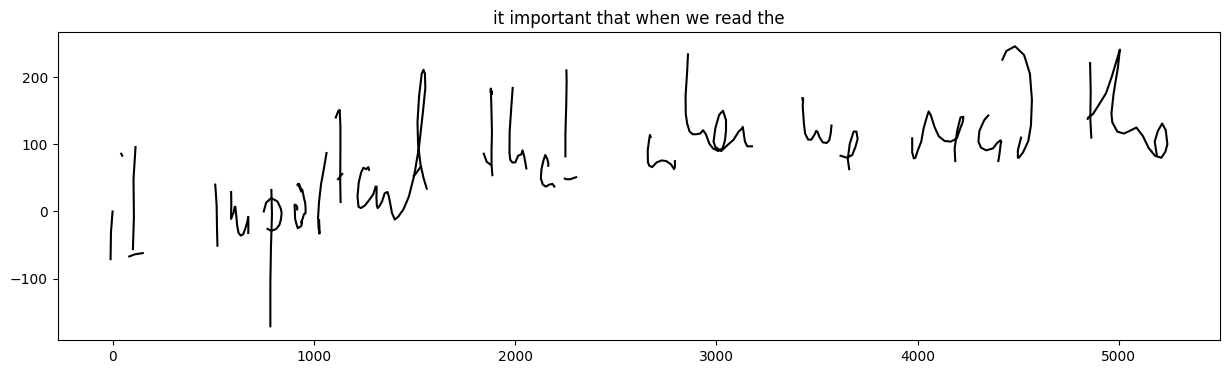

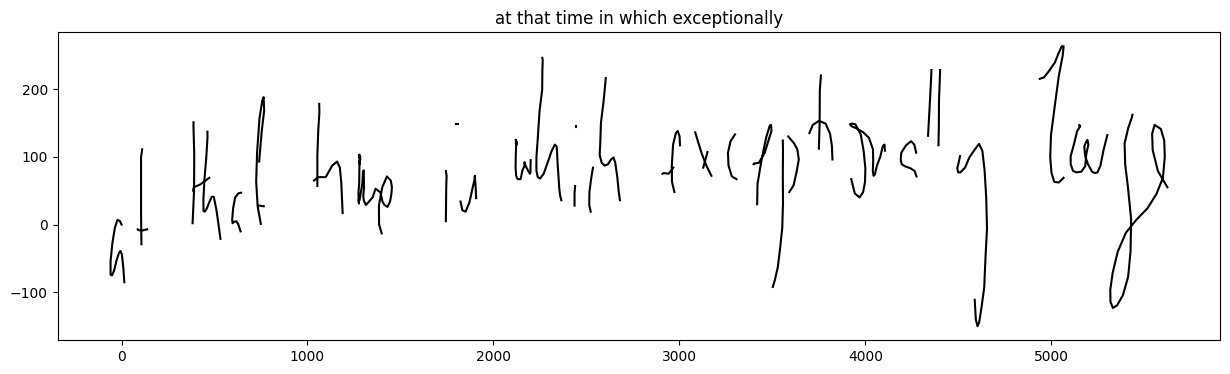

In [1100]:
# Inspect our dataset.  It returns a tuple of stroke offsets and matching ascii strings
# You can see that there isn't an exact match for every subject for strokes to ascii 
# because of the token limit in Transformers
SUB = 7

for s, l in train.batched_onehot_set.take(2).cache():
    plot_stroke(s[0][SUB, :, :], s[1][SUB, :])

In [1336]:
# Basically, I make modifications to the dm-haiku RNN code to fit in the
# attention mechanism and allow a constant character stream to be passed 
# along during dynamic_unroll

from typing import Any, NamedTuple, Optional, Sequence, Tuple, Union

class LSTMState(NamedTuple):
  """An LSTM core state consists of hidden and cell vectors.
  Attributes:
    hidden: Hidden state.
    cell: Cell state.
  """
  hidden: jnp.ndarray
  cell: jnp.ndarray

class LSTMState1(NamedTuple):
  """An LSTM core state consists of hidden and cell vectors.
  Attributes:
    hidden: Hidden state.
    cell: Cell state.
  """
  hidden: jnp.ndarray
  cell: jnp.ndarray
  wt: jnp.ndarray
  kappa: jnp.ndarray
  phi: jnp.ndarray

def add_batch(nest, batch_size):
  """Adds a batch dimension at axis 0 to the leaves of a nested structure."""
  broadcast = lambda x: jnp.broadcast_to(x, (batch_size,) + x.shape)
  return jax.tree_util.tree_map(broadcast, nest)

# Standard LSTM - For regular skip-connected hidden layers
class LSTM_G(hk.RNNCore):
  def __init__(self, hidden_size: int, vocab_size: int, char_len: int, name = None):
    """Constructs an LSTM.
    Args:
      hidden_size: Hidden layer size.
      name: Name of the module.
    """
    super().__init__(name=name)
    self.hidden_size = hidden_size

    self.vocab_size = vocab_size
    self.char_len = char_len

  def __call__(
      self,
      inputs,
      prev_state: LSTMState1,
  ):

    # We ignore the character input for hidden layers

    if len(inputs.shape) > 2 or not inputs.shape:
      raise ValueError("LSTM input must be rank-1 or rank-2.")
    # Don: In Graves he also has weights for the previous cell state
    # So this is just an alternative struture. Maybe still works?

    # Added a custom initialization
    w_init = hk.initializers.RandomNormal(stddev=0.075)

    x_and_h = jnp.concatenate([inputs, prev_state.hidden], axis=-1)
    gated = hk.Linear(4 * self.hidden_size, w_init=w_init)(x_and_h)
    # TODO(slebedev): Consider aligning the order of gates with Sonnet.
    # i = input, g = cell_gate, f = forget_gate, o = output_gate
    i, g, f, o = jnp.split(gated, indices_or_sections=4, axis=-1)
    f = jax.nn.sigmoid(f + 1)  # Forget bias, as in sonnet.
    c = f * prev_state.cell + jax.nn.sigmoid(i) * jnp.tanh(g)
    h = jax.nn.sigmoid(o) * jnp.tanh(c)
    return h, LSTMState1(h, c, prev_state.wt, prev_state.kappa, prev_state.phi)

  def initial_state(self, batch_size) -> LSTMState1:
    state = LSTMState1(hidden=jnp.zeros([self.hidden_size]),
                      cell=jnp.zeros([self.hidden_size]),
                      wt=jnp.zeros(self.vocab_size),
                      kappa=jnp.zeros(K),
                      phi=jnp.zeros(self.char_len))
    if batch_size is not None:
      state = add_batch(state, batch_size)
    return state

# Number of Guassian functions
K = 3

# The first layer LSTM - This one has to accept a window layer from the
# previous timestamp (or default values if it's the first timestep)
# It concatenates the previous window layer with the input and then 
# performs the standard LSTM function. On output it has to pass through 
# the kappa-1 value as well, so that needs to be tracked.
# The output should be ht, wt, kappa
# Higher layers will concat wt with all previous output (skip-connections)
# Kappa-1 will have to be stored in the previous state so that it can be
# accessed by this layer.
class LSTM_G_1(hk.RNNCore):
  def __init__(self, hidden_size: int, vocab_size: int, char_len: int, name = None):
    """Constructs an LSTM.
    Args:
      hidden_size: Hidden layer size.
      name: Name of the module.
    """
    super().__init__(name=name)
    self.hidden_size = hidden_size

    self.vocab_size = vocab_size
    self.char_len = char_len

  def __call__(
      self,
      inputs,
      prev_state: LSTMState1,
  ):

    # inputs[0] = strokes (x)
    # inputs[1] = chars (c)
    if len(inputs[0].shape) > 2 or not inputs[0].shape:
      raise ValueError("LSTM input must be rank-1 or rank-2.")
    # Don: In Graves he also has weights for the previous cell state
    # So this is just an alternative struture. Maybe still works?

    # Added a custom initialization
    w_init = hk.initializers.RandomNormal(stddev=0.075)


    # TODO: needs to be x_and_h_and_w for w_t-1
    x_and_h = jnp.concatenate([inputs[0], prev_state.hidden, prev_state.wt], axis=-1)

    gated = hk.Linear(4 * self.hidden_size, w_init=w_init)(x_and_h)
    # TODO(slebedev): Consider aligning the order of gates with Sonnet.
    # i = input, g = cell_gate, f = forget_gate, o = output_gate
    i, g, f, o = jnp.split(gated, indices_or_sections=4, axis=-1)
    f = jax.nn.sigmoid(f + 1)  # Forget bias, as in sonnet.

    c = f * prev_state.cell + jax.nn.sigmoid(i) * jnp.tanh(g)
    h = jax.nn.sigmoid(o) * jnp.tanh(c)

    # TODO: a, b, k and w_t calculated here (using kappa-1 here)
    attn = hk.Linear(3*K, w_init=w_init)(h)

    attn = jnp.exp(attn)

    #attn = jax.nn.elu(attn) + 1 + EPS

    # Split and reshape to get the window parameters
    alpha, beta, kappa = jnp.split(attn, indices_or_sections=3, axis=-1)

    # This makes sure we always slide forward along the characters as we 
    # write. There is no point in looking backwards to predict the next 
    # strokes.

    kappa = prev_state.kappa + kappa

    # make the window parameters and the character sequence broadcastable
    # We want to calculate individual windows first so [B, U, K, V] - i.e. 
    # K windows per character. Then sum the windows [B, U, V] to get phi.
    # Then sum the characters [B, V], to get w_t
    kappa = jnp.expand_dims(kappa, 2)
    beta = jnp.expand_dims(beta, 2)
    alpha = jnp.expand_dims(alpha, 2)

    # Credit to https://github.com/sjvasquez/handwriting-synthesis for helping
    # me figure out the structure of u. Very nice code and a great version of 
    # this network in python.
    e = jnp.reshape(jnp.arange(self.char_len, dtype='float32'), (1, 1, self.char_len))
    u = jnp.tile(e, (inputs[0].shape[0], 3, 1))

    # Calculate the weighted-sum window for each character [B, U, V]
    phi = jnp.sum(alpha*jnp.exp(-beta*jnp.power((kappa - u), 2)), 1)

    chars = inputs[1]

    wt = jnp.sum(jnp.expand_dims(phi, 2)*chars, 1)

    # Now pass h and wt along the immediate and skip connections
    return h, LSTMState1(h, c, wt, jnp.squeeze(kappa, 2), phi)

  def initial_state(self, batch_size) -> LSTMState1:
    state = LSTMState1(hidden=jnp.zeros([self.hidden_size]),
                      cell=jnp.zeros([self.hidden_size]),
                      wt=jnp.zeros(self.vocab_size),
                      kappa=jnp.zeros(K),
                      phi=jnp.zeros(self.char_len))
    if batch_size is not None:
      state = add_batch(state, batch_size)
    return state

# TODO: Needs regularization

# Custom DeepRNN to match Graves' - The skip connections go from input to each 
# layer and then from each layer to the last layer. The connections are also 
# additions and not concatenations
class DeepRNN_G(hk.RNNCore):
  """Underlying implementation of DeepRNN with skip connections."""

  def __init__(
      self,
      layers,
      out_dims,
#      skip_connections=True,
      name = None
  ):
    super().__init__(name=name)
    self.layers = layers
    #self.skip_connections = skip_connections
    self.out_dims = out_dims

    #if skip_connections:
    # for layer in layers:
    #   if not isinstance(layer, hk.RNNCore):
    #     raise ValueError("skip_connections requires for all layers to be "
    #                        "`hk.RNNCore`s. Layers is: {}".format(layers))

  def __call__(self, inputs, state):
    current_inputs = inputs
    next_states = []
    outputs = []
    state_idx = 0

    #print(inputs)

    #concat = lambda *args: jnp.concatenate(args, axis=-1)
    for idx, layer in enumerate(self.layers):
      # if self.skip_connections and idx > 0:
      #   current_inputs = jax.tree_util.tree_map(concat, inputs, current_inputs)

      # if isinstance(layer, hk.RNNCore):
      #   current_inputs, next_state = layer(current_inputs, state[state_idx])
      #   outputs.append(current_inputs)
      #   next_states.append(next_state)
      #   state_idx += 1
      # else:
      #   current_inputs = layer(current_inputs)

      # For the first layer it has the window and needs the characters in addition
      # to the strokes
      if idx == 0:
        current_inputs, next_state = layer(current_inputs, state[state_idx])
        wt = next_state.wt
      else:
        # Don: I will define the layers explicitly for testing and modification
        #if self.skip_connections and idx > 0:
        # We always concatentate the original input
        current_inputs = jnp.concatenate((inputs[0], current_inputs, wt), axis=-1)
        
        #if isinstance(layer, hk.RNNCore):
        # Now apply the layer, initializing it with the previous states (h-1, c-1)
        current_inputs, next_state = layer(current_inputs, state[state_idx])
        # We also need to save the outputs and we will concatenate them all at 
        # the end

      outputs.append(current_inputs)
      # Build up the list of current states (h, c)
      next_states.append(next_state)
      state_idx += 1

    # if self.skip_connections:
    #   out = jax.tree_util.tree_map(concat, *outputs)
    # else:
    #   out = current_inputs

    #print(*outputs)

    out = jnp.concatenate(outputs, axis=-1)

    # Built in output layer to output the desired logits dimensions
    #out = hk.Linear(self.out_dims)(out)

    return out, tuple(next_states)

  def initial_state(self, batch_size):
    return tuple(
        layer.initial_state(batch_size)
        for layer in self.layers
        if isinstance(layer, hk.RNNCore))

In [1104]:
from haiku._src import base
inside_transform = base.inside_transform

def _swap_batch_time(inputs):
  """Swaps batch and time axes, assumed to be the first two axes."""
  return jax.tree_util.tree_map(lambda x: jnp.swapaxes(x, 0, 1), inputs)

# I am making a small edit so that it will not step over the character input
# This version will allow a tuple of inputs, but only unroll over the first 
# sequence, and always pass the full second sequence
def dynamic_unroll_g(core,
                   input_sequence,
                   initial_state,
                   time_major=True,
                   reverse=False,
                   return_all_states=False,
                   unroll=1):
  """Performs a dynamic unroll of an RNN.
    """

  c_sequence = input_sequence[1]
  input_sequence = input_sequence[0]

  scan = hk.scan if inside_transform() else jax.lax.scan

  # Swap the input and output of core.
  def scan_f(prev_state, inputs):
    outputs, next_state = core((inputs, c_sequence), prev_state)
    if return_all_states:
      return next_state, (outputs, next_state)
    return next_state, outputs

  # TODO(hamzamerzic): Remove axis swapping once scan supports time axis arg.
  if not time_major:
    input_sequence = _swap_batch_time(input_sequence)

  scan_result = scan(
      scan_f, initial_state, input_sequence, reverse=reverse, unroll=unroll)
  if return_all_states:
    _, (output_sequence, state_sequence) = scan_result
  else:
    last_state, output_sequence = scan_result

  if not time_major:
    output_sequence = _swap_batch_time(output_sequence)
    if return_all_states:
      state_sequence = _swap_batch_time(state_sequence)

  if return_all_states:
    return output_sequence, state_sequence
  return output_sequence, last_state

# Section 4 of Graves' 2014 paper - Handwriting Prediction
# This is a fairly vanialla LSTM based RNN that should make convincing 
# gibberish writing, given that we are not defining any attention
# mechanism

HIDDEN_SIZE = 400

# Output space - number of parameters in the mixture model
NUM_MIX_COM = 20
# weights + means (x + y) + std. devs. (x + y) + correlations + end_of_stroke
# Unlike the Mixture Density Network notebook we are going to add cross correlation
# terms to our loss and sampling functions for added complexity of the density 
# estimations
NUM_PARAMS = NUM_MIX_COM + NUM_MIX_COM*2 + NUM_MIX_COM*2 + NUM_MIX_COM + 1

# 3 hidden layers of 400 LSTM cells each - We don't simply feed one into the next
# but also add skip connections from one connection to the next. Basically these 
# are residual connections to prevent vanishing gradients.
def forward_net(x):
  core = DeepRNN_G([
      LSTM_G_1(HIDDEN_SIZE, len(train.vocab)+1, train.MAX_CHAR_SEQ_LEN),
      LSTM_G(HIDDEN_SIZE, len(train.vocab)+1, train.MAX_CHAR_SEQ_LEN),
      LSTM_G(HIDDEN_SIZE, len(train.vocab)+1, train.MAX_CHAR_SEQ_LEN)
  ], NUM_PARAMS)
  out_net = hk.Linear(NUM_PARAMS)

  initial_state = core.initial_state(x[0].shape[0])
  logits, state = dynamic_unroll_g(core, x, initial_state, time_major=False)
  out = hk.BatchApply(out_net)(logits)

  return out, state

In [1105]:
# Now for the loss function
# TODO: I think there are a lot of edge cases here that will result in NaNs when training.

EPS = 0.0000001

LOG2PI = jnp.log(2*jnp.pi)

@jax.jit
def my_loss_fun_MDN(params, batch: tuple) -> jnp.ndarray:
    # Predict the next strokes

    # We split the input and then use 1 sample ahead as the target (y_true)
    inp = batch[0][:, :-1]
    y_true = batch[0][:, 1:]

    logits, _ = network.apply(params, None, (inp, batch[1]))

    pis, mu, sig, rho, eos = jnp.array_split(logits, [NUM_MIX_COM, NUM_MIX_COM*3, NUM_MIX_COM*5, NUM_MIX_COM*6], axis=-1)
    
    # weights - must be a probability distribution so softmax over all components
    pis = jax.nn.softmax(pis)
    
    # means - no transformation needed
    mu_x1, mu_x2 = jnp.array_split(mu, 2, axis=-1)
    
    # standard deviations - must be strictly positive so exponent
    #sig = jnp.exp(sig)

    # More numerically stable without the need for clipping
    sig = jax.nn.elu(sig) + 1 + EPS
    
    #sig = jnp.clip(sig, EPS, np.inf)
    
    sig_x1, sig_x2 = jnp.array_split(sig, 2, axis=-1)
    
    x1, x2, eos_true = jnp.array_split(y_true, 3, axis=-1)
    
    eos_true = jnp.squeeze(eos_true)
        
    # correlations - squish to -1 to 1 with tanh activation
    rho = jnp.tanh(rho)
    
    # Define Z as in Graves, 2013
    Z = jnp.square( ( x1-mu_x1 ) / sig_x1 ) + jnp.square( ( x2-mu_x2 ) / sig_x2 ) - ( 2 * rho * (x1-mu_x1) * (x2-mu_x2) ) / ( sig_x1*sig_x2 )
    
    one_minus_rho_square = 1. - jnp.square(rho)
    
    # Now form Gaussian mixtures
    #term1 = jnp.divide(1., ( 2. * np.pi * sig_x1 * sig_x2 * jnp.sqrt( one_minus_rho_square ) ))
    # This exp is causing instability during training
    #term2 = jnp.exp( jnp.divide ( (-1. * Z) , (2.*( one_minus_rho_square )) ))

    # I switched this to logsumexp for numeric stability
    term3 = jnp.divide ( (-1. * Z) , (2.*( one_minus_rho_square )) )
    term4 = -LOG2PI - jnp.log(sig_x1 * sig_x2) - 0.5 * jnp.log(one_minus_rho_square)

    mix_loss = jax.nn.logsumexp(jnp.log(pis) + term3 + term4, axis=-1)

    # end of stroke loss
    eos = jnp.squeeze(jax.nn.sigmoid(eos))
    
    eos = jnp.clip(eos, EPS, 1.-EPS)

    eos_loss = jnp.where(jnp.equal(eos_true, 1.), eos, 1.-eos)
    
    # Only the valid parts of the sequence should count towards the loss.  The invalid parts are tagged with -2200
    val_seq = jnp.squeeze(jnp.not_equal(eos_true, train.padding_value))

    # This is the total loss for each element (batch * num_timepoints)
    tot_loss = -(mix_loss + jnp.log(eos_loss))

    # The sequence loss is the sum of only the valid timepoints
    
    tot_loss = jnp.where(val_seq, tot_loss, 0.)   
    
    seq_tot = jnp.sum(val_seq, axis=-1, dtype=float)

    tot_loss_s = jnp.sum(tot_loss, axis=-1)

    #tot_loss = tot_loss_s / seq_tot

    # Return the mean loss [1]
    return jnp.mean(tot_loss_s)

In [1106]:
# Training

SEED = 5

EPOCHS = 500

GRAD_CLIP_VALUE = 100
LEARNING_RATE = 0.0001

total_steps = EPOCHS*191 + EPOCHS

optimiser = optax.chain(
      optax.clip_by_global_norm(GRAD_CLIP_VALUE),
      optax.rmsprop(learning_rate=LEARNING_RATE, decay=0.95, eps=0.0001, momentum=0.9),
  )

network = hk.transform(forward_net)

@jax.jit
def update(params: hk.Params, opt_state: optax.OptState, batch: tuple):
  #rng, new_rng = jax.random.split(rng)
  #loss_and_grad_fn = jax.value_and_grad(my_loss_fun_MDN.apply)
  loss, grads = jax.value_and_grad(my_loss_fun_MDN)(params, batch)
  updates, opt_state = optimiser.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return params, opt_state, loss

# TODO: make fetching the iterator more elegant and does the conversion from numpy to jax slow things down?
data_iter = train.batched_onehot_set.prefetch(tf.data.experimental.AUTOTUNE).as_numpy_iterator()

rng = jax.random.PRNGKey(SEED)
rng, init_rng = jax.random.split(rng)
params = network.init(rng=init_rng, x=data_iter.next()[0])
opt_state = optimiser.init(params)

In [ ]:
# TODO: Some kind of elegant checkpointing. For now you can just use this for manual
# saving and loading
# Save the parameters
import pickle

with open('gRNN_checkpoint.pickle', 'wb') as handle:
  pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1125]:
# Load the parameters - included with this project
import pickle

with open('gRNN_checkpoint_2.pickle', 'rb') as handle:
  params = pickle.load(handle)

In [ ]:
#EPOCHS = 200

# LEARNING_RATE = 0.00001
# optimiser = optax.chain(
#       optax.clip_by_global_norm(GRAD_CLIP_VALUE),
#       optax.rmsprop(learning_rate=LEARNING_RATE, decay=0.95, eps=0.0001, momentum=0.9),
#       #optax.adam(learning_rate=LEARNING_RATE)
#   )

train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')

for step in range(EPOCHS):
  data_iter = train.batched_onehot_set.prefetch(tf.data.experimental.AUTOTUNE).as_numpy_iterator()

  train_loss.reset_states()
  val_loss.reset_states()

  print({"Epoch": step})
  for (batch, (b, _)) in enumerate(data_iter):
    params, opt_state, loss = update(params, opt_state, b)

    train_loss(loss)

    if batch % 50 == 0:
      print(f'Epoch {step + 1} Batch {batch} Loss {train_loss.result():.4f}')

  # What about validation loss?
  data_iter_v = val.batched_onehot_set.prefetch(tf.data.experimental.AUTOTUNE).as_numpy_iterator()
  for (batch, (b, _)) in enumerate(data_iter_v):
    val_loss(my_loss_fun_MDN(params, b)) 

  print(f'Epoch {step + 1} Train Loss {train_loss.result():.4f}')
  print(f'Epoch {step + 1} Val Loss {val_loss.result():.4f}')


In [1127]:
# We also need our own sampling function in this case
from tensorflow_probability.substrates import jax as tfp

# We need this function because tf.linagl.diag has no equivalent in JAX
# Maybe this would be a good idea for a pull request as I have seen this
# small code in a lot of JAX code
def fill_diagonal(a, val):
  assert a.ndim >= 2
  i, j = jnp.diag_indices(min(a.shape[-2:]))
  return a.at[..., i, j].set(val)

# sample the mixture model
# input: res (mixture_components)
#        b (temperature)
# output: sample, pis, mean, variance
@jax.jit
def sample_mix_model(res, rng, b):
      #print(res.shape)
      
      pis, mu, sig, rho, eos = jnp.array_split(res, [NUM_MIX_COM, NUM_MIX_COM*3, NUM_MIX_COM*5, NUM_MIX_COM*6], axis=-1)

      # weights - must be a probability distribution so softmax over all components
      pis = jax.nn.softmax(pis * (1.+b))

      # means - no transformation needed
      mu_x1, mu_x2 = jnp.array_split(mu, 2, axis=-1)

      sig = jax.nn.elu(sig - b) + 1 + EPS

      sig_x1, sig_x2 = jnp.array_split(sig, 2, axis=-1)
            
      # correlations - squish to -1 to 1 with tanh activation
      rho = jnp.tanh(rho)

      a = jnp.zeros((NUM_MIX_COM, 2, 2))

      S = fill_diagonal(a, jnp.stack([sig_x1, sig_x2], axis=-1))

      E = jnp.repeat(jnp.eye(2)[None, :], NUM_MIX_COM, axis=0)

      rho_exp = jnp.reshape(jnp.repeat(rho, 4), [NUM_MIX_COM, 2, 2])
    
      corr_mat = jnp.where(jnp.equal(E, 1.), E, rho_exp)
      
      cov_mat = jnp.matmul(S, corr_mat)
      cov_mat = jnp.matmul(cov_mat, S)

      # The distribution is a mixture of gaussians
      gm = tfp.distributions.MixtureSameFamily(mixture_distribution=tfp.distributions.Categorical(probs=pis),
            components_distribution=tfp.distributions.MultivariateNormalTriL(loc=jnp.stack([mu_x1, mu_x2], axis=-1),
                                                                    scale_tril=jax.lax.linalg.cholesky(cov_mat)))

      # End of stroke
      eos = jax.nn.sigmoid(eos)
      
      bd = tfp.distributions.Bernoulli(probs=eos, dtype=float)
      
      rng, new_rng = jax.random.split(rng)

      bd_samp = bd.sample(seed=new_rng)

      rng, new_rng = jax.random.split(rng)
      
      gm_samp = gm.sample(seed=new_rng)

      return jnp.hstack((gm_samp, bd_samp, gm.mean(), gm.covariance().ravel(), pis)), rng

In [1337]:
# Now we need an evaluate function that will take in a character sequence and 
# generate some writing

# Convert a sentence to a one-hot-encoded vector
def convert_sentence(sentence):
  # Convert it to a one-hot encoded vector for the encoder
  U_conv = tf.keras.backend.one_hot(train.text_to_int(sentence), len(train.vocab)+1)
  # Pad it to match the original data that was input into the encoder
  U_conv = tf.keras.preprocessing.sequence.pad_sequences([U_conv],
                                                         maxlen=train.MAX_CHAR_SEQ_LEN,
                                                         padding='post',
                                                         value=train.char_padding_value);

  return jnp.asarray(U_conv)

In [1280]:
def fast_autoregressive_forward_net(context, oh_sentence, seq_len, b, seed):
  core = DeepRNN_G([
    LSTM_G_1(HIDDEN_SIZE, len(train.vocab)+1, train.MAX_CHAR_SEQ_LEN),
    LSTM_G(HIDDEN_SIZE, len(train.vocab)+1, train.MAX_CHAR_SEQ_LEN),
    LSTM_G(HIDDEN_SIZE, len(train.vocab)+1, train.MAX_CHAR_SEQ_LEN)
  ], NUM_PARAMS)
  out_net = hk.Linear(NUM_PARAMS)

  initial_state = core.initial_state(1)
  logits, state = dynamic_unroll_g(core, (context, oh_sentence), initial_state, time_major=False)
  out = hk.BatchApply(out_net)(logits)

  rng = jax.random.PRNGKey(seed)

  x, rng = sample_mix_model(out[0,0,:], rng, b)

  x = x[jnp.newaxis, :3]

  # phis will be one less than the total number of strokes because we want to includ the initial
  # (0,0,0) stroke as a starting point
  stroke_output = jnp.zeros((seq_len, 3))
  stroke_output = stroke_output.at[0, :].set(context[0,0,:])
  stroke_output = stroke_output.at[1, :].set(x[0,:])

  # TODO: Append all phis properly for a long context sequence. Right now the context is only 
  # one stroke long.
  # 3 states will come out of the dynamic_unroll, run for each layer of the RNN, but only the 
  # first layer has the relevant phis because this is the one with the built in window layer 
  # that also accepts the previous window layer as input
  phis = jnp.zeros((seq_len-1, 75))

  phis = phis.at[0, :].set(state[0].phi[0,:])


  def get_strokes(n, carry):
    stroke_output, phis, state, rng = carry

    rng, new_rng = jax.random.split(rng)

    x = stroke_output[n, :]

    x = jnp.expand_dims(x, 0)

    x, state = core((x, oh_sentence), state)
    x = out_net(x)

    x, rng = sample_mix_model(x[0,:], rng, b)

    stroke_output = stroke_output.at[n+1, :].set(x[:3])
    phis = phis.at[n, :].set(state[0].phi[0,:])

    return stroke_output, phis, state, rng

  stroke_output, phis, state, rng = jax.lax.fori_loop(1, seq_len-1, get_strokes, (stroke_output, phis, state, rng))

  return stroke_output, phis

In [1286]:
encoding_sent = 'eeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee'

one_hot_sentence = convert_sentence(encoding_sent)

fast_stroke_predict = hk.transform(fast_autoregressive_forward_net)
#fast_stroke_predict = jax.jit(fast_stroke_predict.apply, static_argnums=5)

rng = jax.random.PRNGKey(12)

predicted, phis = fast_stroke_predict.apply(params, rng, jnp.zeros((1, 1, 3)), one_hot_sentence, 1000, 1.5, 5)

In [ ]:
# Plotting the phis will let you know if the attention mechinism is working, which in this case it does
# appear to be. This is a replication of Graves' 2014, Fig. 13
plt.figure(num=None, figsize=(15, 5))

plt.imshow(phis[:, :30].T, vmax=2, origin='lower', interpolation='nearest', aspect='auto')

plt.xlabel('Stroke')
plt.ylabel(encoding_sent)

In [1351]:
encoding_sent = 'Hello World from Graves\' RNN'

one_hot_sentence = convert_sentence(encoding_sent)

predicted, phis = fast_stroke_predict.apply(params, rng, jnp.zeros((1, 1, 3)), one_hot_sentence, 1000, 20., 2)

In [ ]:
plot_stroke(predicted, one_hot_sentence[0, :])